# 2. Fine tuning with Florence 2 for object detection
Models: 
- https://huggingface.co/microsoft/Florence-2-large
- https://huggingface.co/microsoft/Florence-2-base

Document: https://arxiv.org/abs/2311.06242

<img src="florence2_1.jpg">

<img src="florence2_2.jpg">

In [1]:
import base64
import json
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import os
import re
import sys
import time
import torch

from IPython.display import display, HTML
from peft import LoraConfig, get_peft_model
from PIL import Image, ImageDraw, ImageFont
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from transformers import (AdamW, AutoModelForCausalLM, AutoProcessor,
                          get_scheduler)
from typing import List, Dict, Any, Tuple, Generator

In [2]:
sys.version

'3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]'

## 1. Settings

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [5]:
!nvidia-smi

Tue Jan 14 10:36:20 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-16GB           On  | 00000001:00:00.0 Off |                    0 |
| N/A   29C    P0              25W / 250W |      4MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
model_id = 'microsoft/Florence-2-base'  # or 'microsoft/Florence-2-large'

model = AutoModelForCausalLM.from_pretrained(model_id,
                                             trust_remote_code=True).to(DEVICE)

processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


## 2. Class and functions

In [7]:
class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self) -> List[Dict[str, Any]]:
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        try:
            image = Image.open(image_path)
            return (image, entry)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")


class DetectionDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = data['prefix']
        suffix = data['suffix']
        return prefix, suffix, image

In [8]:
def collate_fn(batch):
    """
    Collates a batch of data for processing.

    Args:
        batch (list): A list of tuples, where each tuple contains a question (str), an answer (str), and an image.

    Returns:
        tuple: A tuple containing:
            - inputs (dict): A dictionary of processed inputs, including tokenized text and images, converted to PyTorch tensors and moved to the                   specified device.
            - answers (list): A list of answers corresponding to the questions in the batch.
    """
    questions, answers, images = zip(*batch)
    
    inputs = processor(text=list(questions),
                       images=list(images),
                       return_tensors="pt",
                       padding=True).to(DEVICE)

    return inputs, answers

In [9]:
def plot_results(image, bboxes, labels):
    """
    Plots bounding boxes on an image with corresponding labels.

    Args:
        image (ndarray): The image on which to plot the bounding boxes.
        bboxes (list of tuples): A list of bounding boxes, where each bounding box is represented as a tuple (xmin, ymin, xmax, ymax).
        labels (list of str): A list of labels corresponding to each bounding box.

    Returns:
        None: This function displays the image with bounding boxes and labels plotted on it.
    """
    # Options
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    ax = plt.gca()
    
    # PArsing the bboxes
    for bbox, label in zip(bboxes, labels):
        xmin, ymin, xmax, ymax = bbox
        width = xmax - xmin
        height = ymax - ymin
        rect = plt.Rectangle((xmin, ymin),
                             width,
                             height,
                             fill=False,
                             edgecolor='lime',
                             linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin,
                ymin - 2,
                label,
                bbox=dict(facecolor='lime', alpha=0.5),
                fontsize=12,
                color='white')

    plt.axis('off')
    plt.show()

In [10]:
def florence2_results(model, dataset: DetectionDataset, count: int):
    """
    Generates inference results for a given model and dataset, and plots bounding boxes on images.

    Args:
        model: The object detection model to be used for inference.
        dataset (DetectionDataset): The dataset containing images and corresponding annotations.
        count (int): The number of images to process from the dataset.

    Returns:
        dict: A dictionary containing the parsed answer for the last processed image, 
        including bounding boxes and labels.
    """
    count = min(count, len(dataset))

    for idx in range(count):
        image, data = dataset.dataset[idx]
        prefix = data['prefix']
        suffix = data['suffix']
        inputs = processor(text=prefix, images=image,
                           return_tensors="pt").to(DEVICE)
        #inputs = processor(text=prompt, images=image, return_tensors="pt")

        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            early_stopping=False,
            do_sample=False,
            num_beams=3,
        )
        generated_text = processor.batch_decode(generated_ids,
                                                skip_special_tokens=False)[0]
        
        results = processor.post_process_generation(
            generated_text,
            task='<OD>',
            image_size=(image.width, image.height))
        
        # Access bounding boxes and labels
        od_results = results['<OD>']
        bboxes = od_results['bboxes']
        labels = od_results['labels']

        # Plot bounding boxes on the image using the separate function
        plot_results(image, bboxes, labels)

    return results

In [26]:
def finetuning_model_training(train_loader,
                              val_loader,
                              model,
                              processor,
                              epochs=10,
                              lr=1e-6):
    """
    Trains an object detection model using the provided training and validation data loaders.

    Args:
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        model: The object detection model to be trained.
        processor: The processor used for tokenizing text and images.
        epochs (int, optional): The number of training epochs. Default is 10.
        lr (float, optional): The learning rate for the optimizer. Default is 1e-6.

    Returns:
        None: This function prints the average training and validation losses for each epoch 
        and saves the model and processor checkpoints.
    """
    optimizer = AdamW(model.parameters(), lr=lr)
    
    num_training_steps = epochs * len(train_loader)
    
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, answers in tqdm(
                train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False).input_ids.to(DEVICE)

            outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            labels=labels)
            loss = outputs.loss

            loss.backward(), optimizer.step(), lr_scheduler.step(
            ), optimizer.zero_grad()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        model.eval()
        
        val_loss = 0
        with torch.no_grad():
            for inputs, answers in tqdm(
                    val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(
                    text=answers,
                    return_tensors="pt",
                    padding=True,
                    return_token_type_ids=False).input_ids.to(DEVICE)

                outputs = model(input_ids=input_ids,
                                pixel_values=pixel_values,
                                labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Average Validation Loss: {avg_val_loss}")

            florence2_results(peft_model, val_loader.dataset, 2)

        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)

## 3. Fine tuning

In [12]:
TRAIN_DIR = "images/train"
VALID_DIR = "images/valid"

train_json_file = os.path.join(TRAIN_DIR, "images/train_annotations.json")
valid_json_file = os.path.join(VALID_DIR, "images/val_annotations.json")

In [13]:
with open(train_json_file, 'r') as f:
    print(f.read())

{"image":"IMG20221202152341_jpg.rf.41ac9781b32138f1b6f12f1b8b972304.jpg","prefix":"<OD>","suffix":"Digital Trainer<loc_139><loc_0><loc_764><loc_1000>"}
{"image":"IMG20221202152341_jpg.rf.44ae75ecfd97a3c7d0cf710405dae65d.jpg","prefix":"<OD>","suffix":"Digital Trainer<loc_128><loc_0><loc_738><loc_1000>"}
{"image":"IMG20221202152341_jpg.rf.6a610faf48d9a1af13c1cc34ece5cf13.jpg","prefix":"<OD>","suffix":"Digital Trainer<loc_247><loc_0><loc_886><loc_1000>"}
{"image":"IMG20221202152341_jpg.rf.7c203b6a86a19e7c1ddd96f1014aeef0.jpg","prefix":"<OD>","suffix":"Digital Trainer<loc_200><loc_114><loc_685><loc_922>"}
{"image":"IMG20221202152341_jpg.rf.8c6655d16765511317d90965a266acc3.jpg","prefix":"<OD>","suffix":"Digital Trainer<loc_237><loc_0><loc_867><loc_1000>"}
{"image":"IMG20221202152341_jpg.rf.f509a54c227d473c952d0f45da7f2c78.jpg","prefix":"<OD>","suffix":"Digital Trainer<loc_200><loc_114><loc_685><loc_922>"}
{"image":"IMG20221202152352_jpg.rf.547c8a3f5146adb765efbd6f96ce3ca1.jpg","prefix":"<OD

In [14]:
with open(valid_json_file, 'r') as f:
    print(f.read())

{"image":"IMG20221202152443_jpg.rf.a53845305c7cd1bc2c837329650d8d2d.jpg","prefix":"<OD>","suffix":"Digital Trainer<loc_216><loc_233><loc_689><loc_799>"}
{"image":"IMG20221202152451_jpg.rf.d40a3ff6ea203ca256ffe6c3f16e8831.jpg","prefix":"<OD>","suffix":"Digital Trainer<loc_199><loc_272><loc_679><loc_714>"}
{"image":"IMG20221202152556_jpg.rf.d99458e2abd5a37a40bb9b5499900a13.jpg","prefix":"<OD>","suffix":"Digital Trainer<loc_374><loc_376><loc_559><loc_573>"}
{"image":"IMG20221202152758_jpg.rf.75828f7537d57cfb5446f410e6142c8d.jpg","prefix":"<OD>","suffix":"Oscilloscope<loc_181><loc_188><loc_656><loc_890>"}
{"image":"IMG20221202152805_jpg.rf.c18e9c436a0aa03824e7ebe04943eb21.jpg","prefix":"<OD>","suffix":"Oscilloscope<loc_338><loc_180><loc_491><loc_650>"}
{"image":"IMG20221202152816_jpg.rf.8a1fa3162c9d415fcadc1513320732f1.jpg","prefix":"<OD>","suffix":"Oscilloscope<loc_328><loc_219><loc_656><loc_843>"}
{"image":"IMG20221202152823_jpg.rf.56a7aee15cf8725bfb26e9901f4e210a.jpg","prefix":"<OD>","s

In [15]:
BATCH_SIZE = 4
NUM_WORKERS = 0

In [16]:
train_dataset = DetectionDataset(
    jsonl_file_path=train_json_file,
    image_directory_path=f"{TRAIN_DIR}/images"
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)

In [17]:
val_dataset = DetectionDataset(
    jsonl_file_path=valid_json_file,
    image_directory_path=f"{VALID_DIR}/images"
)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        collate_fn=collate_fn, num_workers=NUM_WORKERS)

In [18]:
# Setup LoRA Florence-2 model

config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=[
        "q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head",
        "fc2"
    ],
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
)

peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()

trainable params: 1,929,928 || all params: 272,733,896 || trainable%: 0.7076


In [19]:
peft_model 

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Florence2ForConditionalGeneration(
      (vision_tower): DaViT(
        (convs): ModuleList(
          (0): ConvEmbed(
            (proj): Conv2d(3, 128, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): ConvEmbed(
            (proj): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (2): ConvEmbed(
            (proj): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          )
          (3): ConvEmbed(
            (proj): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          )
        )
        (blocks): ModuleList(
      

## 4. Testing object detection using the baseline Florence2 model

In [20]:
torch.cuda.empty_cache()

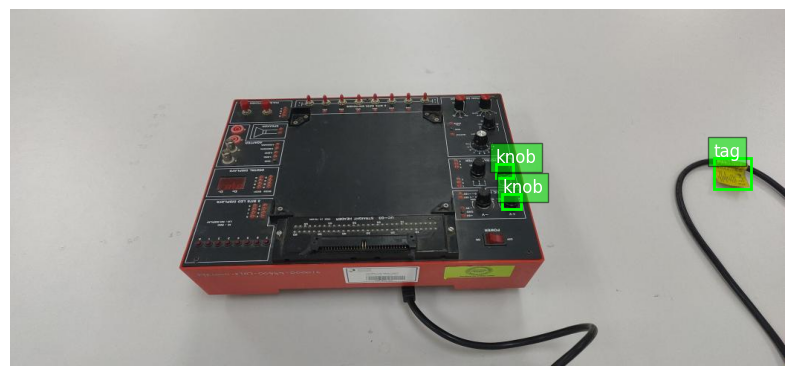

In [21]:
results = florence2_results(peft_model, val_dataset, 1)

In [22]:
results

{'<OD>': {'bboxes': [[661.7835083007812,
    247.9199981689453,
    686.8154907226562,
    268.0799865722656],
   [653.4395141601562,
    207.1199951171875,
    676.385498046875,
    225.83999633789062],
   [946.5224609375,
    199.44000244140625,
    996.5864868164062,
    240.72000122070312]],
  'labels': ['knob', 'knob', 'tag']}}

In [23]:
bboxes = results['<OD>']['bboxes']
labels = results['<OD>']['labels']

for idx, (bbox, label) in enumerate(zip(bboxes, labels), start=1):
    print(f"{idx} : {label} with Bounding Box: {bbox}")

1 : knob with Bounding Box: [661.7835083007812, 247.9199981689453, 686.8154907226562, 268.0799865722656]
2 : knob with Bounding Box: [653.4395141601562, 207.1199951171875, 676.385498046875, 225.83999633789062]
3 : tag with Bounding Box: [946.5224609375, 199.44000244140625, 996.5864868164062, 240.72000122070312]


## 5. Fine tuning florence2

In [24]:
EPOCHS = 10
LR = 4e-6

Florence 2 fine tuning for object detection...



Training Epoch 1/10: 100%|██████████| 595/595 [08:07<00:00,  1.22it/s]


Average Training Loss: 1.3286111497077622


Validation Epoch 1/10: 100%|██████████| 31/31 [00:14<00:00,  2.07it/s]


Average Validation Loss: 1.230867124372913


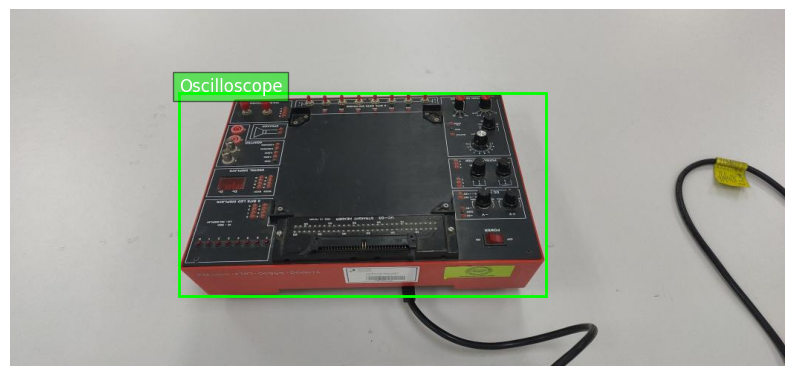

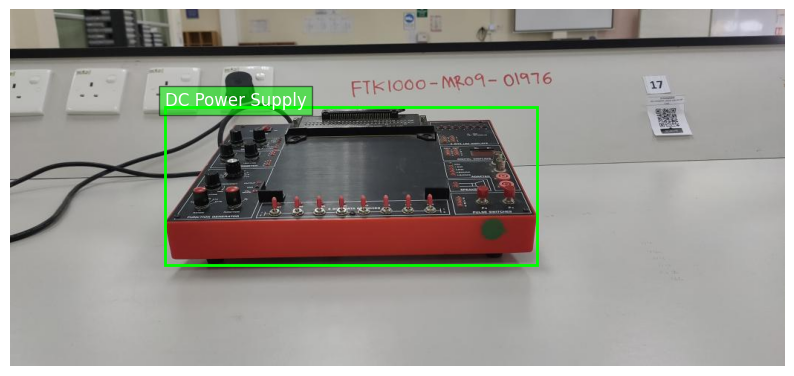

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
Training Epoch 2/10: 100%|██████████| 595/595 [07:28<00:00,  1.33it/s]


Average Training Loss: 1.0712233512341476


Validation Epoch 2/10: 100%|██████████| 31/31 [00:13<00:00,  2.22it/s]


Average Validation Loss: 1.1663755774497986


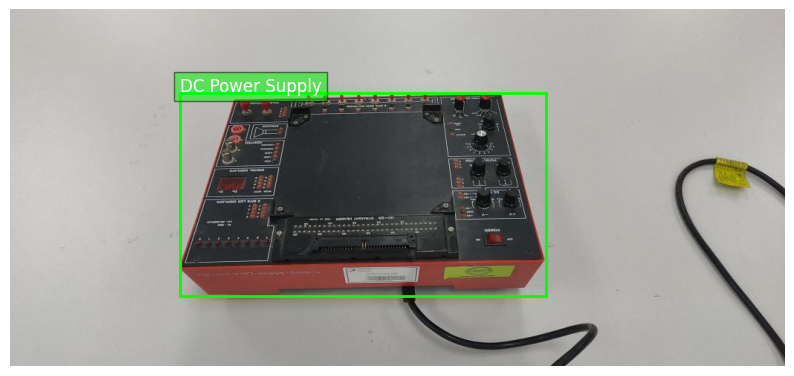

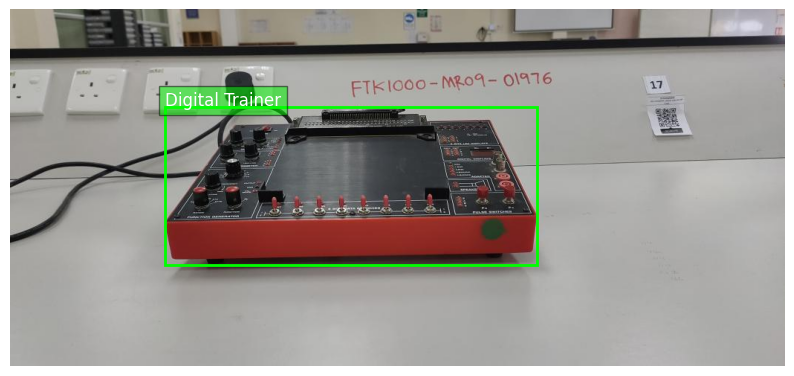

Training Epoch 3/10: 100%|██████████| 595/595 [07:32<00:00,  1.32it/s]


Average Training Loss: 1.0094939788850417


Validation Epoch 3/10: 100%|██████████| 31/31 [00:14<00:00,  2.20it/s]


Average Validation Loss: 1.1264868109456954


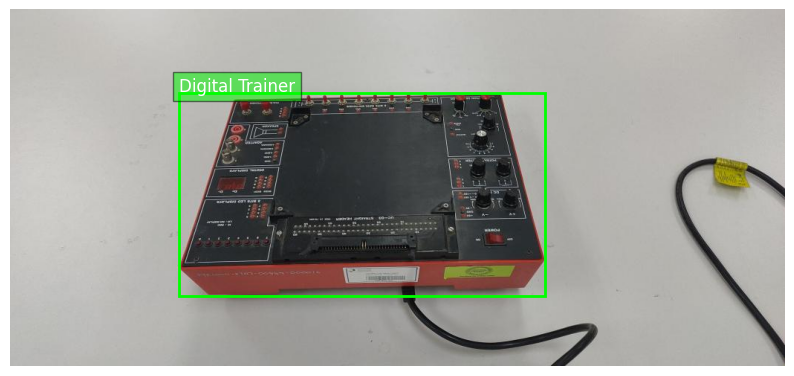

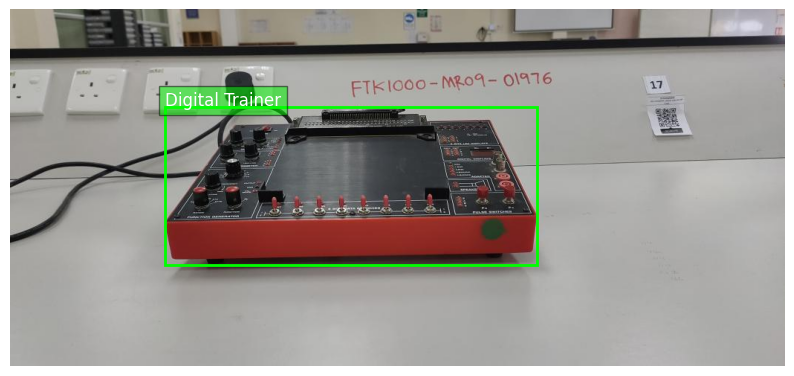

Training Epoch 4/10: 100%|██████████| 595/595 [07:25<00:00,  1.33it/s]


Average Training Loss: 0.9623759925365448


Validation Epoch 4/10: 100%|██████████| 31/31 [00:13<00:00,  2.22it/s]


Average Validation Loss: 1.0994236603859933


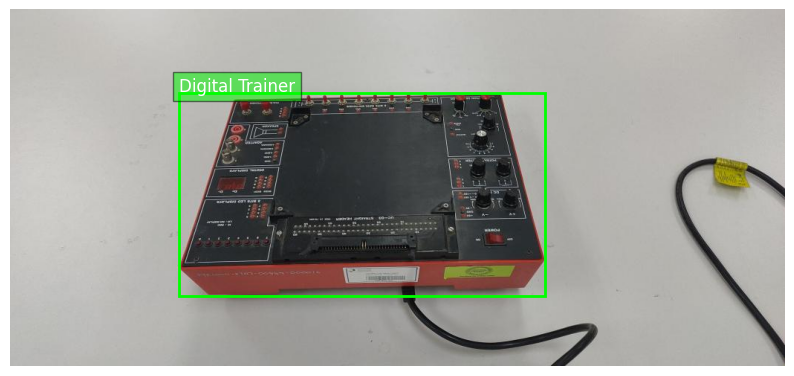

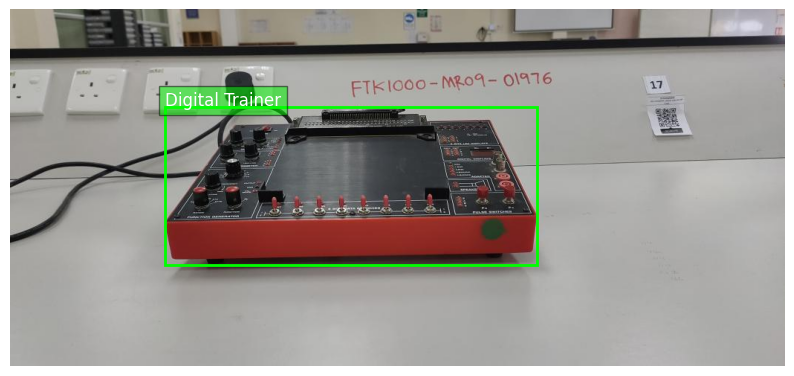

Training Epoch 5/10: 100%|██████████| 595/595 [07:29<00:00,  1.32it/s]


Average Training Loss: 0.9314922129907528


Validation Epoch 5/10: 100%|██████████| 31/31 [00:14<00:00,  2.18it/s]


Average Validation Loss: 1.0844301312200484


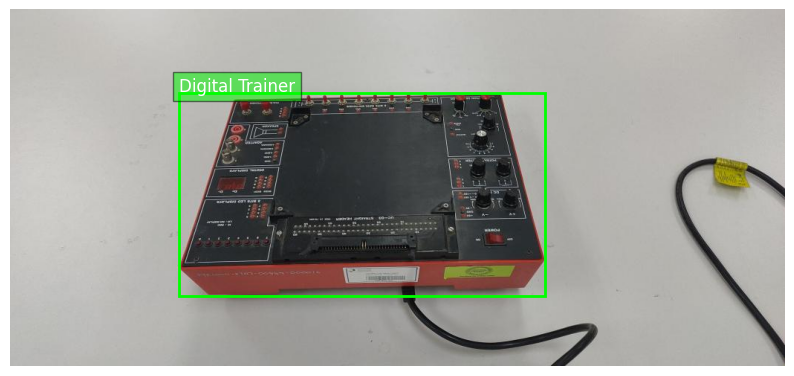

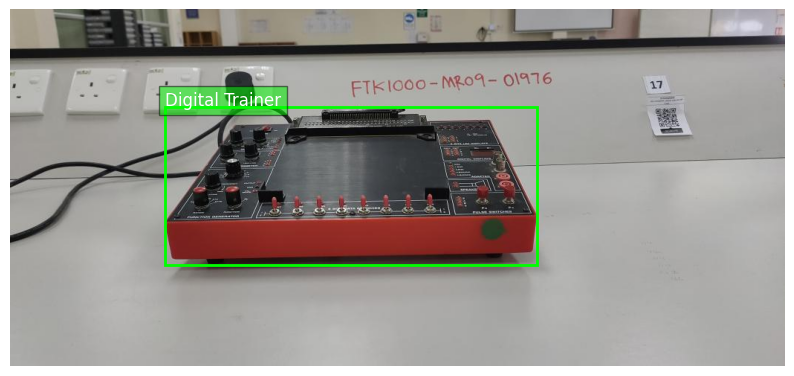

Training Epoch 6/10: 100%|██████████| 595/595 [07:31<00:00,  1.32it/s]


Average Training Loss: 0.9153964583112412


Validation Epoch 6/10: 100%|██████████| 31/31 [00:14<00:00,  2.15it/s]


Average Validation Loss: 1.0694744529262665


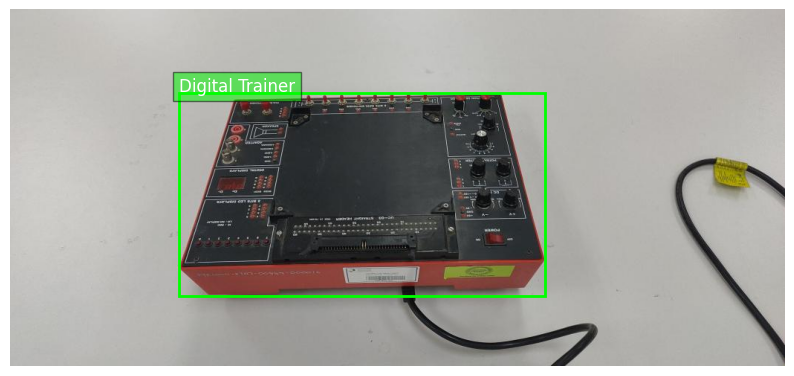

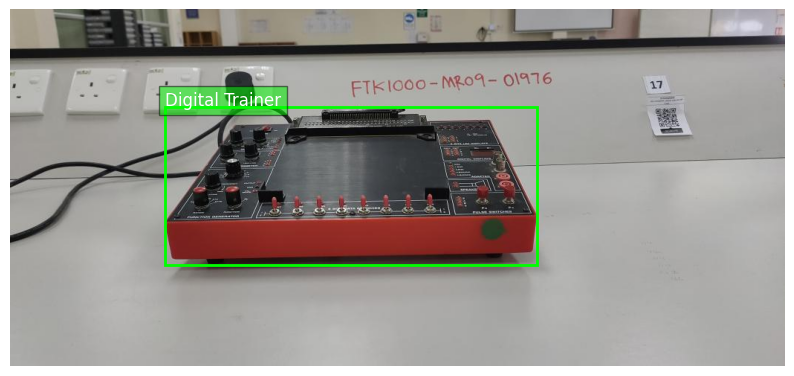

Training Epoch 7/10: 100%|██████████| 595/595 [07:28<00:00,  1.33it/s]


Average Training Loss: 0.9050671655089916


Validation Epoch 7/10: 100%|██████████| 31/31 [00:13<00:00,  2.24it/s]


Average Validation Loss: 1.0627213851098092


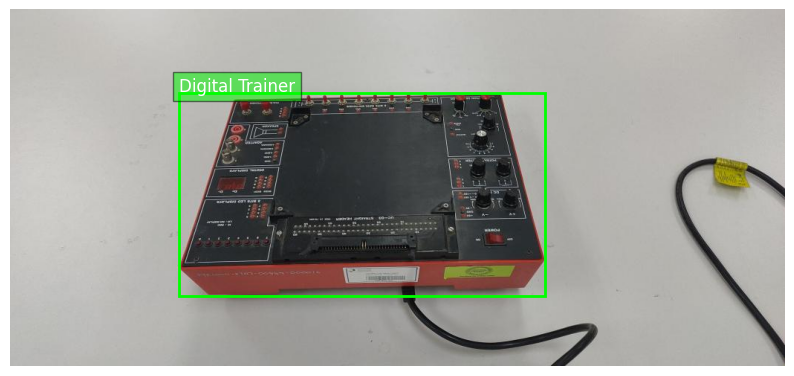

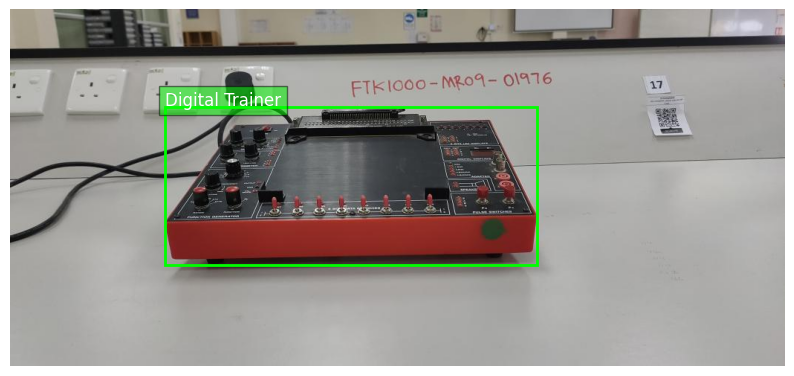

Training Epoch 8/10: 100%|██████████| 595/595 [07:24<00:00,  1.34it/s]


Average Training Loss: 0.8837636839441892


Validation Epoch 8/10: 100%|██████████| 31/31 [00:14<00:00,  2.21it/s]


Average Validation Loss: 1.0566051717727416


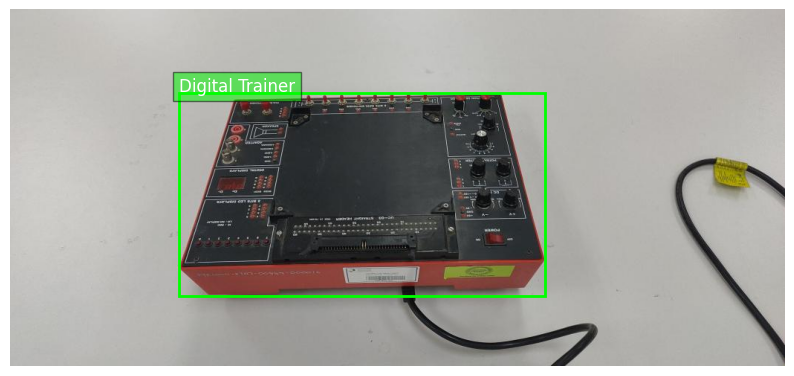

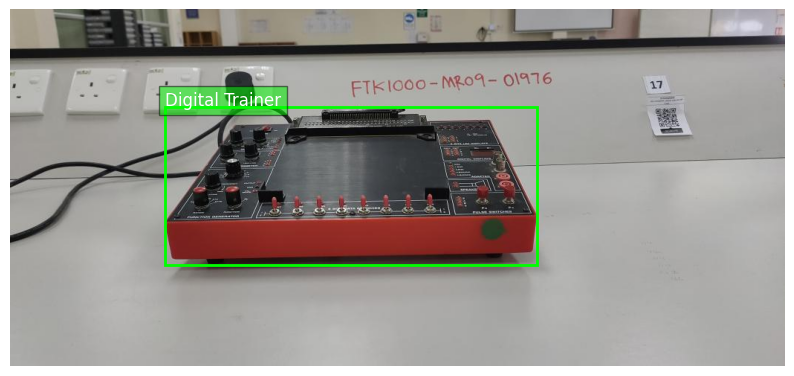

Training Epoch 9/10: 100%|██████████| 595/595 [07:30<00:00,  1.32it/s]


Average Training Loss: 0.8727069380403567


Validation Epoch 9/10: 100%|██████████| 31/31 [00:14<00:00,  2.18it/s]


Average Validation Loss: 1.054076971546296


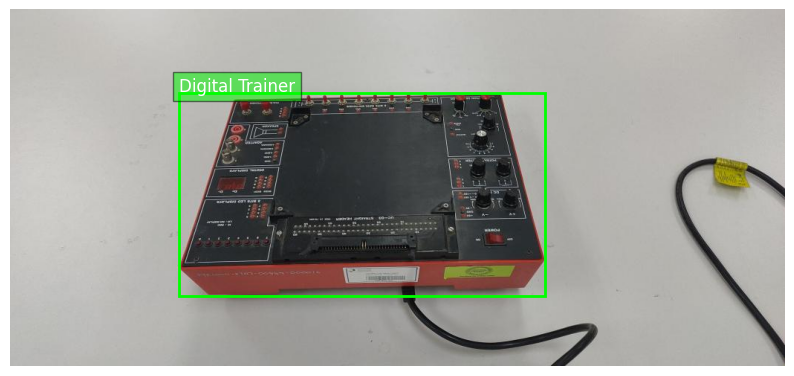

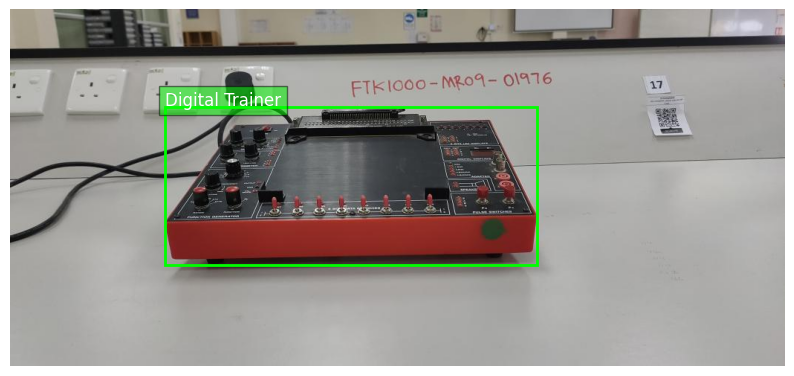

Training Epoch 10/10: 100%|██████████| 595/595 [07:30<00:00,  1.32it/s]


Average Training Loss: 0.8726561982090734


Validation Epoch 10/10: 100%|██████████| 31/31 [00:14<00:00,  2.16it/s]


Average Validation Loss: 1.0535099698651222


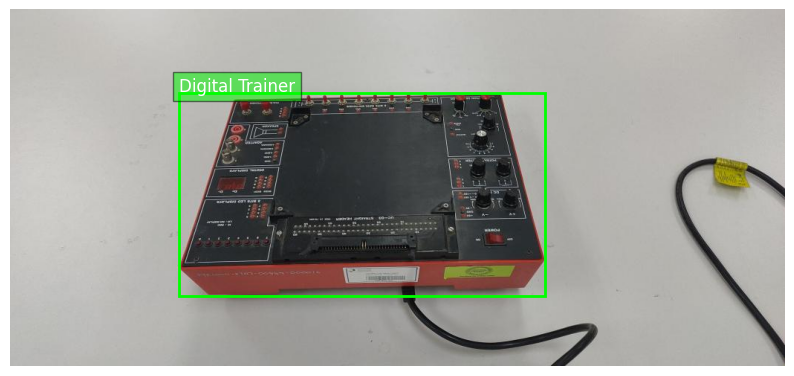

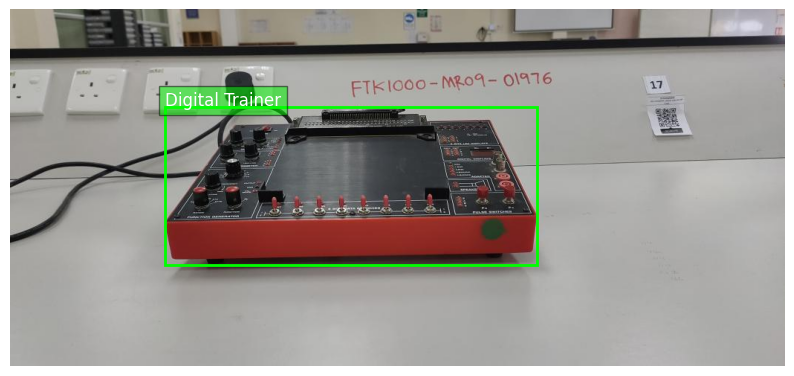


Completed in 01:18:11.1459062099456


In [27]:
start = time.time()

print("Florence 2 fine tuning for object detection...\n")
finetuning_model_training(train_loader,
                          val_loader,
                          peft_model,
                          processor,
                          epochs=EPOCHS,
                          lr=LR)

elapsed = time.time() - start
print(f"\nCompleted in {time.strftime('%H:%M:%S.' + str(elapsed % 1)[2:15], time.gmtime(elapsed))}")

In [28]:
os.listdir("model_checkpoints")

['epoch_1',
 'epoch_10',
 'epoch_2',
 'epoch_3',
 'epoch_4',
 'epoch_5',
 'epoch_6',
 'epoch_7',
 'epoch_8',
 'epoch_9']